# Case 3 Medical text categorization
Tony Kuitunen<br>
1503242<br>
Cognitive Systems for Health Technology Applications<br>
24.2.2018<br>
[Helsinki Metropolia University of Applied Sciences](http:/www.metropolia.fi/en)

#### Task
Task is to use recurrent and convolutional neural networks to create a classifier for a
collection of medical abstracts extracted from MEDLINE, the online medical information
database.

In [1]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras import callbacks
from keras.layers import Flatten, Dense, Embedding, Conv1D, LSTM, Dropout, MaxPooling1D, Activation, BatchNormalization
from keras import regularizers

from sklearn.metrics import accuracy_score, precision_score, f1_score, confusion_matrix
from sklearn.metrics import classification_report, recall_score

import matplotlib.pyplot as plt
import numpy as np
import os
import time

Using TensorFlow backend.


# Preprocess

#### Process raw data
* Make a list of every label    
* There will be 23 labels

Based on listing 6.8 (p. 189) Chollet: Deep Learning with Python, 2018.

In [2]:
ohsumed_dir = 'ohsumed-first-20000-docs/'
train_dir = os.path.join(ohsumed_dir, 'training')

labels = []
texts = []

# Generate a list L = ['C01', 'C02, ..., 'C023']
L = ['C{:02}'.format(n) for n in range(1, 23 + 1)]
for label_type in L:
    dir_name = os.path.join(train_dir, label_type)
    for fname in os.listdir(dir_name):
        f = open(os.path.join(dir_name, fname))
        texts.append(f.read())
        f.close()
        i = L.index(label_type)
        labels.append(i)

#### Tokenize the text of the raw data
* Make a dictionary with maximum size of 25000 words out of the text
* Use tokenizer to find all different words
Based on listing 6.9 (p. 189)

In [3]:
maxlen = 60
max_words = 10000

tokenizer = Tokenizer(num_words = max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Found %s unique tokens' % len(word_index))

Found 30857 unique tokens


#### Shape the data and labels
* Take 80 first words from the texts, this seems to get most of the data without need for zero padding so much
* encode them with one-hot

In [4]:
data = pad_sequences(sequences, maxlen = maxlen)

labels = np.asarray(labels)
one_hot_labels = to_categorical(labels)


print('Shape of data tensor:', data.shape)
print('Shape of labels tensor:', one_hot_labels.shape)

Shape of data tensor: (10433, 60)
Shape of labels tensor: (10433, 23)


#### Shuffle the data and labels
* Shuffle labels and data the sameway

In [5]:
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]
one_hot_labels = one_hot_labels[indices]

In [6]:
print(data[indices[512]])
print(texts[indices[512]])

[1088  158  143 4009 2161  334  213    4 2002   16    4 3953 4009    5 1167
 1748 1532 2161 1518  213    4 2002   16    4 3953 2854    2    1  291 2052
  139  358 5830 2681    4    1 7395 1748  291 4101    2 2002   14 2342    1
 1828 2674 1138    3 2997    1 1138    2  196   24    7  409 1192  105 2139]
Pleuropulmonary tularemia: successful treatment with erythromycin.
 A 64-year-old man had community-acquired pneumonia that was retrospectively diagnosed as pleuropulmonary tularemia.
 He was successfully treated with erythromycin.
 We review the case and briefly discuss the literature on this point.



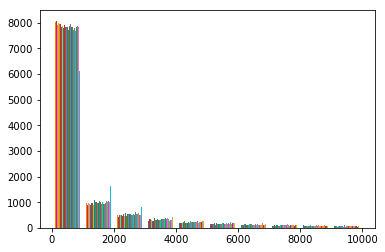

In [161]:
plt.hist(data)
plt.show()

## Build the 1st model
* Use word embedding
* Use 1D convolutional layer
* Use regularization to prevent overfit
* Use dropout to prevent overfit
* Use Batch normalization to prevent overfit
* Use smaller learning rate to prevent stucking in strange spot    
Listing 6.7 (p. 187)

In [162]:
#kernel_regularizer=regularizers.l1(0.01)
model = Sequential()
model.add(Embedding(max_words, 64, input_length=maxlen))

model.add(Conv1D(32, 3, kernel_regularizer=regularizers.l1(0.01)))
model.add(BatchNormalization())
model.add(Dropout(0.1))
model.add(MaxPooling1D(2))

model.add(Conv1D(64, 3, kernel_regularizer=regularizers.l1(0.01)))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(MaxPooling1D(2))


model.add(Flatten())
model.add(Dense(1024, activation = 'relu', kernel_regularizer=regularizers.l1(0.01)))
model.add(Dropout(0.3))
model.add(Dense(256, activation = 'relu'))
model.add(Dropout(0.3))
#model.add(Dense(128, activation = 'relu'))
#model.add(Dense(64, activation = 'relu'))
model.add(Dense(len(L), activation = 'softmax'))

from keras import optimizers
rmsprop = optimizers.RMSprop(lr=0.003)


model.compile(optimizer = rmsprop,
             loss = 'categorical_crossentropy',
             metrics = ['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_56 (Embedding)     (None, 60, 64)            640000    
_________________________________________________________________
conv1d_95 (Conv1D)           (None, 58, 32)            6176      
_________________________________________________________________
batch_normalization_54 (Batc (None, 58, 32)            128       
_________________________________________________________________
dropout_36 (Dropout)         (None, 58, 32)            0         
_________________________________________________________________
max_pooling1d_80 (MaxPooling (None, 29, 32)            0         
_________________________________________________________________
conv1d_96 (Conv1D)           (None, 27, 64)            6208      
_________________________________________________________________
batch_normalization_55 (Batc (None, 27, 64)            256       
__________

In [36]:
#model.fit(data, one_hot_labels,epochs = 1,batch_size = 32,validation_split = 0.2)

#### Train the model
* Make a callback after each epoch and save the model only if it has gotten better

In [164]:
filepath = 'saves\\case3_first.hdf5'
modelcheckpoint = callbacks.ModelCheckpoint(filepath, monitor='val_acc', verbose=0, save_best_only=True, save_weights_only=False, mode='auto', period=1)

t1 = time.time()
history = model.fit(data, one_hot_labels,
                   epochs = 60,
                   batch_size = 128,
                   validation_split = 0.2,
                   verbose = 0,
                   callbacks=[modelcheckpoint])
t2 = time.time()
modeltime=t2-t1
print('Elapsed time: {:.2f} seconds'.format((t2-t1)))

Elapsed time: 833.89 seconds


#### Plot the results in a graph
* Make a function to easen this process later

In [16]:
def plotHistory(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    epoch = history.epoch

    plt.plot(epoch,loss)
    plt.plot(epoch,val_loss)
    plt.legend(['loss','val_loss'])
    plt.title("Loss")
    plt.show()

    plt.plot(epoch,acc)
    plt.plot(epoch,val_acc)
    plt.legend(['acc','val_acc'])
    plt.title("Accuracy")
    plt.show()
    
plotHistory(history)

## Build 2nd model
* Make use of LSTM RNN network rather than 1D convolutional network
* Make word embeddings 

In [166]:
#kernel_regularizer=regularizers.l1(0.01)
lmodel = Sequential()
lmodel.add(Embedding(max_words, 92, input_length=maxlen))

lmodel.add(LSTM(92, dropout=0.2, recurrent_dropout=0.2))
lmodel.add(Dense(64, activation = 'relu', kernel_regularizer=regularizers.l1(0.01)))
lmodel.add(Dropout(0.3))
lmodel.add(Dense(len(L), activation = 'softmax'))

from keras import optimizers
rmsprop = optimizers.RMSprop()


lmodel.compile(optimizer = rmsprop,
             loss = 'categorical_crossentropy',
             metrics = ['accuracy'])

lmodel.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_57 (Embedding)     (None, 60, 92)            920000    
_________________________________________________________________
lstm_8 (LSTM)                (None, 92)                68080     
_________________________________________________________________
dense_159 (Dense)            (None, 64)                5952      
_________________________________________________________________
dropout_40 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_160 (Dense)            (None, 23)                1495      
Total params: 995,527
Trainable params: 995,527
Non-trainable params: 0
_________________________________________________________________


In [167]:
#lmodel.fit(data, one_hot_labels,epochs = 1,batch_size = 64,validation_split = 0.2)

In [168]:
lfilepath = 'saves\\case3_second.hdf5'
lmodelcheckpoint = callbacks.ModelCheckpoint(lfilepath, monitor='val_acc', verbose=0, save_best_only=True, save_weights_only=False, mode='auto', period=1)

t1 = time.time()
lhistory = lmodel.fit(data, one_hot_labels,
                    epochs = 60,
                    batch_size = 128,
                    validation_split = 0.2,
                    verbose = 0,
                    callbacks=[lmodelcheckpoint])
t2 = time.time()
lmodeltime=t2-t1
print('Elapsed time: {:.2f} seconds'.format((t2-t1)))

Elapsed time: 2318.91 seconds


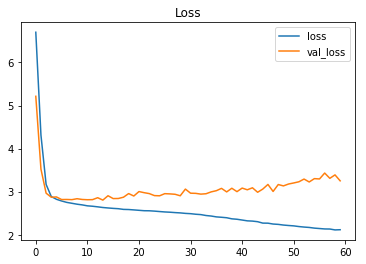

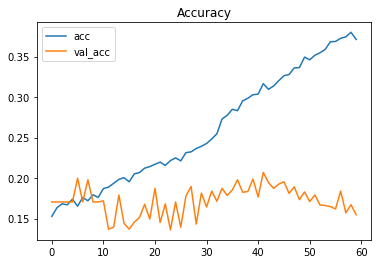

In [169]:
plotHistory(lhistory)

## Build model using both
* Use both LSTM NRR and 1D convolutional layers + Dense network to categorize
* Use batch normalization before activation function to prevent overfitting
* Use regularization to prevent overfitting
* Use dropout layers to prevent overfitting
* Use faster learning rate with decay to prevent getting stuck

In [31]:
#kernel_regularizer=regularizers.l1(0.01)
bmodel = Sequential()

bmodel.add(Embedding(max_words, 92, input_length=maxlen))

bmodel.add(Conv1D(64, 3, input_shape=(100, 100),kernel_regularizer=regularizers.l2(0.01)))
bmodel.add(BatchNormalization())
bmodel.add(Activation('relu'))

#bmodel.add(Conv1D(64, 3, input_shape=(100, 100),kernel_regularizer=regularizers.l2(0.01)))
#bmodel.add(BatchNormalization())
#bmodel.add(Activation('relu'))

bmodel.add(MaxPooling1D(3))

#bmodel.add(Conv1D(128, 3, input_shape=(100, 100)))
#bmodel.add(BatchNormalization())
#bmodel.add(Activation('relu'))

bmodel.add(Conv1D(128, 3, input_shape=(100, 100)))
bmodel.add(BatchNormalization())
bmodel.add(Activation('relu'))

bmodel.add(MaxPooling1D(3))

bmodel.add(LSTM(92, dropout=0.2, recurrent_dropout=0.2))

bmodel.add(Dense(64, kernel_regularizer=regularizers.l2(0.01)))
bmodel.add(BatchNormalization())
bmodel.add(Activation('relu'))
bmodel.add(Dropout(0.3))

bmodel.add(Dense(len(L), activation = 'softmax'))

from keras import optimizers
rmsprop = optimizers.RMSprop(lr=0.025, decay=0.01)


bmodel.compile(optimizer = rmsprop,
             loss = 'categorical_crossentropy',
             metrics = ['accuracy'])

bmodel.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_14 (Embedding)     (None, 60, 92)            920000    
_________________________________________________________________
conv1d_47 (Conv1D)           (None, 58, 64)            17728     
_________________________________________________________________
batch_normalization_54 (Batc (None, 58, 64)            256       
_________________________________________________________________
activation_54 (Activation)   (None, 58, 64)            0         
_________________________________________________________________
max_pooling1d_27 (MaxPooling (None, 19, 64)            0         
_________________________________________________________________
conv1d_48 (Conv1D)           (None, 17, 128)           24704     
_________________________________________________________________
batch_normalization_55 (Batc (None, 17, 128)           512       
__________

In [32]:
bfilepath = 'saves\\case3_three.hdf5'
bmodelcheckpoint = callbacks.ModelCheckpoint(bfilepath, monitor='val_acc', verbose=0, save_best_only=True, save_weights_only=False, mode='auto', period=1)

t1 = time.time()
bhistory = bmodel.fit(data, one_hot_labels,
                    epochs = 10,
                    batch_size = 128,
                    validation_split = 0.2,
                    verbose = 1,
                    callbacks=[bmodelcheckpoint])
t2 = time.time()
bmodeltime=t2-t1
print('Elapsed time: {:.2f} seconds'.format((t2-t1)))

Train on 8346 samples, validate on 2087 samples
Epoch 1/10
8346/8346 [==============================] - 30s 4ms/step - loss: 3.5173 - acc: 0.1524 - val_loss: 3.1138 - val_acc: 0.1682

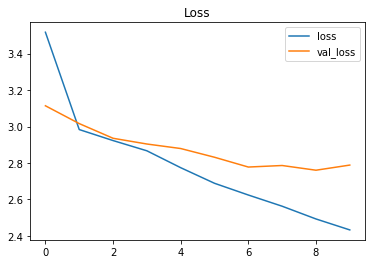

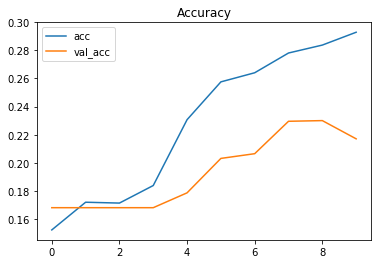

In [33]:
plotHistory(bhistory)

## Metrics results and comparison

* load the test dataset
* make predictions with the model and test dataset
* try loading the models that had lowest accuracy, this will probably not be efficient as all models started overfitting with validation data almost immediately
* make classification reports and compare them

#### take test dataset

In [34]:
ohsumed_dir = 'ohsumed-first-20000-docs/'
test_dir = os.path.join(ohsumed_dir, 'test')

test_labels = []
test_texts = []

# Generate a list L = ['C01', 'C02, ..., 'C023']
L = ['C{:02}'.format(n) for n in range(1, 23 + 1)]
for label_type in L:
    dir_name = os.path.join(test_dir, label_type)
    for fname in os.listdir(dir_name):
        f = open(os.path.join(dir_name, fname))
        test_texts.append(f.read())
        f.close()
        i = L.index(label_type)
        test_labels.append(i)
        
tokenizer = Tokenizer(num_words = max_words)
tokenizer.fit_on_texts(test_texts)
test_sequences = tokenizer.texts_to_sequences(test_texts)

test_word_index = tokenizer.word_index
test_data = pad_sequences(test_sequences, maxlen = maxlen)

test_labels = np.asarray(test_labels)

print('Shape of data tensor:', data.shape)
print('Shape of labels tensor:', one_hot_labels.shape)

Shape of data tensor: (10433, 60)
Shape of labels tensor: (10433, 23)


The test set is as big as the training set. This would have been useful information before training the models as most of these samples could have been used in training

#### Make predictions

In [42]:
from keras import models

# Calculate the predictions of 1st
model = models.load_model(filepath)
predictions = model.predict(test_data)
y_pred = np.argmax(predictions, axis = 1)

#Try loading for example LSTM model from memory at the point it had best val_acc
lmodel = models.load_model(lfilepath)
lpredictions = lmodel.predict(test_data)
ly_pred = np.argmax(lpredictions, axis = 1)

#last model with both
bmodel = models.load_model(bfilepath)
bpredictions = bmodel.predict(test_data)
by_pred = np.argmax(bpredictions, axis = 1)

 http://scikit-learn.org/stable/modules/model_evaluation.html

#### Classification results per class
* First off is the 1D-convolutional model

In [43]:
print(classification_report(test_labels, y_pred))

             precision    recall  f1-score   support

          0       0.00      0.00      0.00       506
          1       0.00      0.00      0.00       233
          2       0.00      0.00      0.00        70
          3       0.10      0.00      0.00      1467
          4       0.00      0.00      0.00       429
          5       0.00      0.00      0.00       632
          6       0.00      0.00      0.00       146
          7       0.00      0.00      0.00       600
          8       0.00      0.00      0.00       129
          9       0.00      0.00      0.00       941
         10       0.00      0.00      0.00       202
         11       0.00      0.00      0.00       548
         12       0.00      0.00      0.00       386
         13       0.11      0.20      0.15      1301
         14       0.00      0.00      0.00       320
         15       0.00      0.00      0.00       228
         16       0.00      0.00      0.00       348
         17       0.00      0.00      0.00   

C:\Users\Tony\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


* second is the LSTM model

In [44]:
print(classification_report(test_labels, ly_pred))

             precision    recall  f1-score   support

          0       0.00      0.00      0.00       506
          1       0.00      0.00      0.00       233
          2       0.00      0.00      0.00        70
          3       0.12      0.09      0.10      1467
          4       0.00      0.00      0.00       429
          5       0.00      0.00      0.00       632
          6       0.00      0.00      0.00       146
          7       0.00      0.00      0.00       600
          8       0.00      0.00      0.00       129
          9       0.00      0.00      0.00       941
         10       0.00      0.00      0.00       202
         11       0.00      0.00      0.00       548
         12       0.00      0.00      0.00       386
         13       0.11      0.11      0.11      1301
         14       0.00      0.00      0.00       320
         15       0.00      0.00      0.00       228
         16       0.00      0.00      0.00       348
         17       0.03      0.01      0.01   

C:\Users\Tony\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


* Third model is with 1D-convolutional layers and LSTM RNN layer

In [45]:
print(classification_report(test_labels, by_pred))

             precision    recall  f1-score   support

          0       0.00      0.00      0.00       506
          1       0.00      0.00      0.00       233
          2       0.00      0.00      0.00        70
          3       0.12      0.19      0.15      1467
          4       0.00      0.00      0.00       429
          5       0.00      0.00      0.00       632
          6       0.00      0.00      0.00       146
          7       0.00      0.00      0.00       600
          8       0.00      0.00      0.00       129
          9       0.00      0.00      0.00       941
         10       0.00      0.00      0.00       202
         11       0.00      0.00      0.00       548
         12       0.00      0.00      0.00       386
         13       0.13      0.08      0.10      1301
         14       0.00      0.00      0.00       320
         15       0.00      0.00      0.00       228
         16       0.00      0.00      0.00       348
         17       0.00      0.00      0.00   

C:\Users\Tony\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


The models all were very heavily overfitted and the 1D Conv + LSTM RNN model was slightly less rubbish than the others.

Even though the last model seemed to go much better in validation accuracy and loss it also is as rubbish as the rest. flipping coin would be 4.5% and predicting the most frequent is 7% 

#### Confusion matrix
* print out confusion matrixes and analyse them

In [46]:
cm = confusion_matrix(test_labels, y_pred)
print(np.array2string(cm, max_line_width = 120))

[[   0    0    0    0    0    0    0    0    0    0    0    0    0   91    0    0    0    0    0    0    0    0  415]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0   34    0    0    0    0    0    0    0    0  199]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0   19    0    0    0    0    0    0    0    0   51]
 [   0    0    0    1    0    0    0    0    0    0    0    0    0  214    0    0    0    0    0    0    0    0 1252]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0   81    0    0    0    0    0    0    0    0  348]
 [   0    0    0    1    0    0    0    0    0    0    0    0    0  110    0    0    0    0    0    0    0    0  521]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0   27    0    0    0    0    0    0    0    0  119]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0  121    0    0    0    0    0    0    0    0  479]
 [   0    0    0    0    0    0    0    0    0    0    0

In [47]:
lcm = confusion_matrix(test_labels, ly_pred)
print(np.array2string(lcm, max_line_width = 120))

[[   0    0    0   58    0    0    0    0    0    0    0    0    0   48    0    0    0    5    0   41   37    0  317]
 [   0    0    0   29    0    0    0    0    0    0    0    0    0   18    0    0    0    1    0   28   22    0  135]
 [   0    0    0    6    0    0    0    0    0    0    0    0    0    9    0    0    0    0    0    3    2    0   50]
 [   0    0    0  134    0    0    0    0    0    0    0    0    0  126    0    0    0    6    0  149  121    0  931]
 [   0    0    0   41    0    0    0    0    0    0    0    0    0   37    0    0    0    1    0   48   37    0  265]
 [   0    0    0   53    0    0    0    0    0    0    0    0    0   54    0    0    0    3    0   58   45    0  419]
 [   0    0    0    7    0    0    0    0    0    0    0    0    0   18    0    0    0    0    0    9    4    0  108]
 [   0    0    0   39    0    0    0    0    0    0    0    0    0   73    0    0    0    6    0   52   38    0  392]
 [   0    0    0    7    0    0    0    0    0    0    0

In [48]:
# Confusion matrix
bcm = confusion_matrix(test_labels, by_pred)
print(np.array2string(bcm, max_line_width = 120))

[[   0    0    0  107    0    0    0    0    0    0    0    0    0   33    0    0    0    0    0    6    0    0  360]
 [   0    0    0   58    0    0    0    0    0    0    0    0    0   15    0    0    0    0    0    1    0    0  159]
 [   0    0    0   10    0    0    0    0    0    0    0    0    0    1    0    0    0    0    0    3    0    0   56]
 [   0    0    0  284    0    0    0    0    0    0    0    0    0   81    0    0    0    0    0   19    0    0 1083]
 [   0    0    0   67    0    0    0    0    0    0    0    0    0   31    0    0    0    0    0    6    0    0  325]
 [   0    0    0  119    0    0    0    0    0    0    0    0    0   38    0    0    0    0    0    4    0    0  471]
 [   0    0    0   17    0    0    0    0    0    0    0    0    0   14    0    0    0    0    0    2    0    0  113]
 [   0    0    0  117    0    0    0    0    0    0    0    0    0   34    0    0    0    0    0    4    0    0  445]
 [   0    0    0   22    0    0    0    0    0    0    0

Based on these convolution matrixes the models don't predict all possible labels, just some and the ones being labeled are pretty much random as the percentage of predictions are similar in each column

Lets try the best model with some prediction

True class:  1
Predicted class: 22
Predictions per class:
[  2.01e-02   7.51e-04   6.53e-04   6.09e-03   1.04e-02   2.43e-02
   2.48e-04   4.00e-02   7.05e-04   8.27e-02   3.76e-03   6.64e-02
   7.58e-03   2.40e-01   1.19e-02   1.33e-02   5.66e-03   1.16e-01
   2.91e-02   4.07e-03   3.88e-02   6.64e-03   2.71e-01]


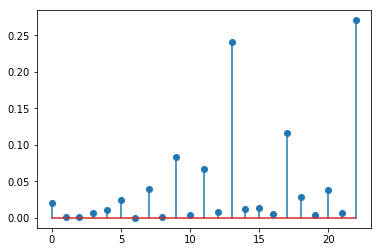

In [49]:
print('True class: ', test_labels[512])
print('Predicted class:', by_pred[512])
print('Predictions per class:')
print(np.array2string(bpredictions[512], precision = 2))

plt.stem(bpredictions[512])
plt.show()

The model is not very certain of the answer on a test case

## Conclusion

The models overfitted from the first epoch on. Necessary regularisations and dropouts were tried to reduce this but with not enough effect. The overfitting curve could only be lowered but not removed. The hardest part was to get the first 1D-convolutional model to move at all. It first got stuck at 0.1711 acc and did not train at all no matter what hyperparameters or preprocessing was done. After that I introduced it with smaller learning rate and more complex models with batch normalization and training accuracy started going up. Of course the validation went just down due to overfitting.

Somewhat bad results were bound to happen as the models did not train at all first with smaller networks and after increasing the size they started to heavily overfit. The training sets should have been much larger and some samples like 5000 atleast could have been taken from the test set. The confusion matrix shows that the predictions lack some labels in general which shows that the model has trained itself on a bad direction.


More training data and more preprocessing maybe could help this. Also making the amount of samples per label more similar. I tried dictionary sizes of 10000, 20000 and 25000 and the smallest trained the fastest without causing problems. Also sample words were tried with 50,80,100,120,200 and 80 seems to work just as well as others. Also the samples mostly only included less than 100 words and some forums suggested the lack of training to be due to zero padding. Maybe the word vectors could be checked as there were 30 000 unique tokens, some of them might be the same with just random noise in them as ' or , or " markings.

I will get back to this problem in the future as this was very tricky. Text analysis is anyway a very interesting problem that I would like to tackle.